In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array 
import matplotlib.pyplot as plt
import time

In [2]:
# 데이터 로딩 함수
def load_data(data_dir, img_size=(128, 128)):
    images = []
    masks = []

    for img_file in os.listdir(data_dir):
        if '_mask' not in img_file:
            img_path = os.path.join(data_dir, img_file)
            mask_path = os.path.join(data_dir, img_file.replace('.jpg', '_mask.jpg'))
    
            img = load_img(img_path, target_size=img_size)
            mask = load_img(mask_path, target_size=img_size, color_mode='grayscale')
    
            img = img_to_array(img) / 255.0
            mask = img_to_array(mask) / 255.0
    
            images.append(img)
            masks.append(mask)

    return np.array(images), np.array(masks)

# 데이터 디렉토리 설정
train_dir = '/kaggle/input/unet1234567/split_datasets/test'
val_dir = '/kaggle/input/unet1234567/split_datasets/val'
test_dir = '/kaggle/input/unet1234567/split_datasets/test'

# 데이터 로딩
X_train, y_train = load_data(train_dir)
X_val, y_val = load_data(val_dir)
X_test, y_test = load_data(test_dir)

In [3]:
# U-Net 모델 정의
def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(input_shape)

    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)

    up7 = layers.concatenate([layers.Conv2DTranspose(128, 2, strides=(2, 2), padding='same')(conv4), conv3], axis=3)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same')(up7)
    conv7 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = layers.concatenate([layers.Conv2DTranspose(64, 2, strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(up8)
    conv8 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv8)
    
    up9 = layers.concatenate([layers.Conv2DTranspose(32, 2, strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(up9)
    conv9 = layers.Conv2D(32, 3, activation='relu', padding='same')(conv9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model
# 교사 모델 생성 및 훈련
teacher_model = build_unet()
teacher_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[])

# 교사 모델 훈련
history_teacher = teacher_model.fit(X_train, y_train,
                                     batch_size=16,
                                     epochs=50,
                                     validation_data=(X_val, y_val))

# 학생 모델 생성
student_model = build_unet()  # 원래 U-Net 구조를 학생 모델로 사용


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - loss: 0.6562 - val_loss: 0.3238
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.2823 - val_loss: 0.2068
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1972 - val_loss: 0.2043
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1922 - val_loss: 0.1993
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1906 - val_loss: 0.1973
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1903 - val_loss: 0.1965
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1841 - val_loss: 0.1909
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1800 - val_loss: 0.1833
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1698 - val_loss: 0.1675
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1591 - val_loss: 0.1791
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1683 - val_loss: 0.1475
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.1383 - val_loss: 0.1495
Ep

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - dice_coef: 0.0319 - loss: 0.9510 - val_dice_coef: 1.1786e-10 - val_loss: 0.9691
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - dice_coef: 1.2156e-10 - loss: 0.9652 - val_dice_coef: 1.1786e-10 - val_loss: 0.9624
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - dice_coef: 1.2189e-10 - loss: 0.9607 - val_dice_coef: 1.1786e-10 - val_loss: 0.9602
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - dice_coef: 1.2108e-10 - loss: 0.9598 - val_dice_coef: 1.1786e-10 - val_loss: 0.9601
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - dice_coef: 1.2231e-10 - loss: 0.9596 - val_dice_coef: 1.1786e-10 - val_loss: 0.9600
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - dice_coef: 1.2327e-10 - loss: 0.9594 - val_dice_coef: 1.1786e-10 - val_loss: 0.9599
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - dice_coef: 1.2318e-10 - loss: 0.9594 - val_dice_coef: 1.1786e-10 - val_loss: 0.9597
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - dice_coef: 1.2510e-10 - loss: 0.9592 - val_dice_coef: 1.1786e-10 - val_loss: 0.9595
4/4 ━━━━━━━━━

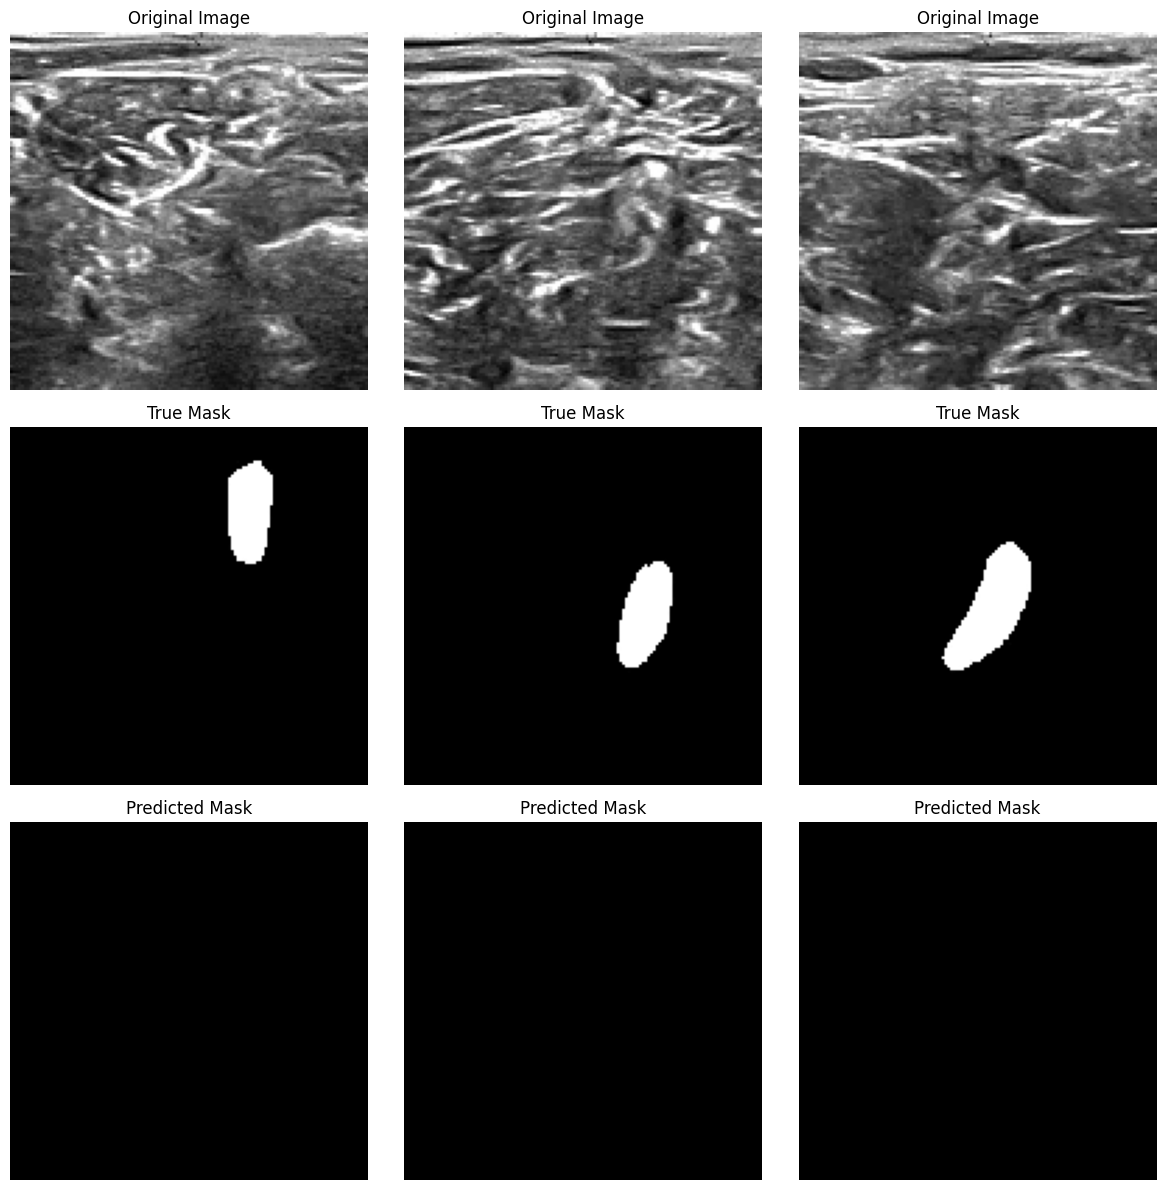

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 966ms/step
모델의 파라미터 수: 1925601 (약 7.35 MB)
예측 시간: 1.0043 초


In [4]:
# 학생 모델 컴파일 (원래 손실 함수와 dice_coef만 사용)
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred > 0.5, dtype=tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def combined_loss(y_true, y_pred, a=0.95):
    logit_loss_value = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=False)
    dice_loss_value = dice_loss(y_true, y_pred)
    return a * dice_loss_value + (1 - a) * logit_loss_value

# 학생 모델 컴파일 (dice_coef만 사용)
student_model.compile(optimizer='adam', loss=combined_loss, metrics=[dice_coef])

# 학생 모델 훈련 함수
def train_student_model(student_model, X_train, y_train, batch_size=16, epochs=50):
    for epoch in range(epochs):
        # 학생 모델 훈련
        history = student_model.fit(X_train, y_train,
                                    batch_size=batch_size,
                                    epochs=1,
                                    verbose=1,
                                    validation_data=(X_val, y_val),
                                    shuffle=True)

# 학생 모델 훈련 시작
train_student_model(student_model, X_train, y_train)

# 베스트 모델 로드
best_model = student_model

# 테스트 데이터 평가
test_loss, test_dice = best_model.evaluate(X_test, y_test)

# 결과 시각화
def visualize_results(model, X, y, num_samples=3):
    predictions = model.predict(X[:num_samples])
    predictions = (predictions > 0.5).astype(np.float32)
    plt.figure(figsize=(4*num_samples, 12))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(X[i])
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(y[i, :, :, 0], cmap='gray')
        plt.title('True Mask')
        plt.axis('off')
        plt.subplot(3, num_samples, i + 1 + 2*num_samples)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_results(best_model, X_test, y_test)

# 모델 사이즈 및 시간 측정 함수
def measure_model_size_and_time(model, sample_input_shape):
    model_size = model.count_params()
    model_size_bytes = model_size * 4  # 각 파라미터가 4바이트(32비트)라고 가정

    sample_input = np.random.rand(*sample_input_shape).astype(np.float32)

    start_time = time.time()
    model.predict(sample_input)
    end_time = time.time()

    inference_time = end_time - start_time

    print(f"모델의 파라미터 수: {model_size} (약 {model_size_bytes / (1024 ** 2):.2f} MB)")
    print(f"예측 시간: {inference_time:.4f} 초")

# 사용 예시
measure_model_size_and_time(best_model, (1, 128, 128, 3))